In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

import functools

import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import keras
from keras import Input, Model
from keras.layers import Dense, LeakyReLU, concatenate
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard
import time

# Load data

In [2]:
def get_dataset(n_instance):
    """
    Create regression data: y = x(1 + f(z)) + g(z)
    """
    t = np.random.random(size=n_instance) * 2 * np.pi - np.pi
    x_ = np.cos(t)
    y_ = np.sin(t)

    i_set = np.arange(0,n_instance,1)
    for i in i_set:
        length = 1 - np.random.random()*0.4
        x_[i] = x_[i] * length
        y_[i] = y_[i] * length

    X = x_.reshape(-1, 1)
    y = y_.reshape(-1, 1)
        
    return X, y

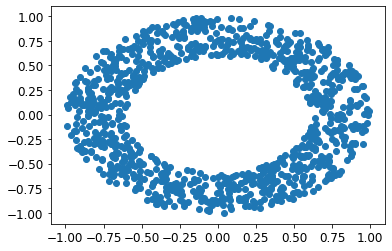

In [3]:
n_instance = 1000
X_train, y_train = get_dataset(n_instance)
X_test, y_test = get_dataset(n_instance)

plt.scatter(X_train,y_train)
plt.show()

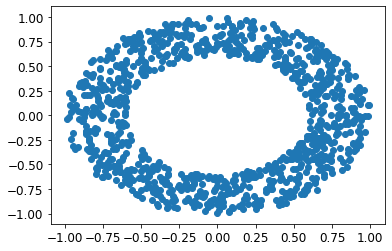

In [4]:
plt.scatter(X_test,y_test)
plt.show()

In [5]:
sample_data = np.concatenate((X_train, y_train), axis=1)
sample_data.shape

(1000, 2)

In [6]:
X_train = sample_data

# Scale the data or not?

In [7]:
from sklearn.preprocessing import *
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(sample_data)*2 - 1
X_train_scaled.shape

(1000, 2)

In [8]:
BATCH_SIZE = 10
latent_space = 3

In [9]:
train_dataset = X_train_scaled.reshape(-1,2,1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_scaled))
train_dataset = train_dataset.batch(BATCH_SIZE)
num=0
for data in train_dataset:
    print("every time the data shape",data.shape)
    num+=1
print("Cycles: ",num)

every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
every time the data shape (10, 2, 1)
e

# Training

In [10]:
def make_generator_model():
    # This will input x & noise and will output Y.
    model = tf.keras.Sequential()
    model.add(Dense(2*4, input_shape=(latent_space,), use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(Dense(2*2, use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    #model.add(Dense(2*4, use_bias=False))
    #model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.LeakyReLU())
    model.add(Dense(2*1, use_bias=False, activation="tanh"))
    model.add(Reshape((2, 1)))
    #model.add(Dense(1, activation="tanh", use_bias=False))
    
    return model

In [11]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 32        
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 16        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8

### Discriminator model

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Dense(2*4, input_shape=(2,1), use_bias=True))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(Dense(2*8, use_bias=True))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))
              
    return model

In [13]:
discriminator = make_discriminator_model()

In [14]:
gan = keras.models.Sequential([generator, discriminator])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2, 8)              16        
_________________________________________________________________
layer_normalization (LayerNo (None, 2, 8)              16        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2, 8)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2, 16)             144       
_________________________________________________________________
layer_normalization_1 (Layer (None, 2, 16)             32        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 2, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 32)               

### change the loss function of generator and discriminator

In [15]:
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output,fake_output):
    return tf.reduce_mean(fake_output)-tf.reduce_mean(real_output)

### change the hyperparameters in Adam

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

### Gradient penalty method

In [17]:
def gradient_penalty(f, real, fake):
    
    def _interpolate(a, b):
        shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
        alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
        inter = a + alpha * (b - a)
        inter.set_shape(a.shape)
        return inter

    x = _interpolate(real, fake)
    with tf.GradientTape() as t:
        t.watch(x)
        pred = f(x)
    grad = t.gradient(pred, x)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)

    return gp

### The training process of generator and discriminator respectively

In [18]:
@tf.function
def train_G(batch):
    with tf.GradientTape() as gen_tape:
        if batch.shape[0]==BATCH_SIZE:
            noise = tf.random.normal([BATCH_SIZE, latent_space])
        else:
            noise = tf.random.normal([10, latent_space])
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    return gen_loss

### In the discriminator training, add the gradient penalty term

In [19]:
@tf.function
def train_D(batch):
    with tf.GradientTape() as disc_tape:
        if batch.shape[0]==BATCH_SIZE:
            noise = tf.random.normal([BATCH_SIZE, latent_space])
        else:
            noise = tf.random.normal([10, latent_space])

        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss_without = discriminator_loss(real_output, fake_output)
        gp = gradient_penalty(functools.partial(discriminator, training=True), batch, generated_images)
        disc_loss = discriminator_loss(real_output, fake_output) + gp*10.0

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss_without

In [20]:
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './content/generator'
discriminator_log_dir = './content/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

In [21]:
generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

_____

### the number of discriminator iterations per generator iteration

In [22]:
n_critic = 5

In [23]:
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [24]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:

            for _ in range(n_critic):
                disc_loss_without = train_D(batch)

            gen_loss = train_G(batch)
            

            generator_mean_loss(gen_loss)
            discriminator_mean_loss(disc_loss_without)
        
        with generator_summary_writer.as_default():
            tf.summary.scalar('generator_loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('discriminator_loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        
        print("discriminator: {:.6f}".format(hist[-1][1]), end=' - ')
        print("generator: {:.6f}".format(hist[-1][0]), end=' - ')    
        print('{:.0f}s'.format( time.time()-start))

        # Global variables are used below
        if epoch%100 == 0:
            #save the model
            gan.save('./content/'+'wgan'+str(epoch)+'.h5')    

            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[10,5])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            #ax.set_yscale('log')
            ax.grid()
            plt.show()
            
    return hist


C:\Users\ellye\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Epoch 1/301
discriminator: 0.134601 - generator: -0.016135 - 6s
Loss: 


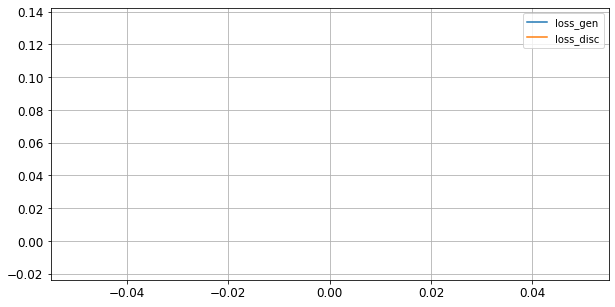

Epoch 2/301
discriminator: 0.132636 - generator: 0.058854 - 1s
Epoch 3/301
discriminator: 0.055018 - generator: 0.135909 - 1s
Epoch 4/301
discriminator: -0.005889 - generator: 0.175389 - 1s
Epoch 5/301
discriminator: -0.049030 - generator: 0.253144 - 2s
Epoch 6/301
discriminator: -0.056662 - generator: 0.353228 - 1s
Epoch 7/301
discriminator: -0.052776 - generator: 0.456123 - 1s
Epoch 8/301
discriminator: -0.048207 - generator: 0.530741 - 1s
Epoch 9/301
discriminator: -0.038732 - generator: 0.550581 - 1s
Epoch 10/301
discriminator: -0.039951 - generator: 0.535767 - 1s
Epoch 11/301
discriminator: -0.035484 - generator: 0.465394 - 1s
Epoch 12/301
discriminator: -0.028271 - generator: 0.422956 - 1s
Epoch 13/301
discriminator: -0.017277 - generator: 0.404955 - 1s
Epoch 14/301
discriminator: -0.006994 - generator: 0.410535 - 1s
Epoch 15/301
discriminator: 0.002925 - generator: 0.420774 - 1s
Epoch 16/301
discriminator: -0.001737 - generator: 0.450077 - 1s
Epoch 17/301
discriminator: 0.004818

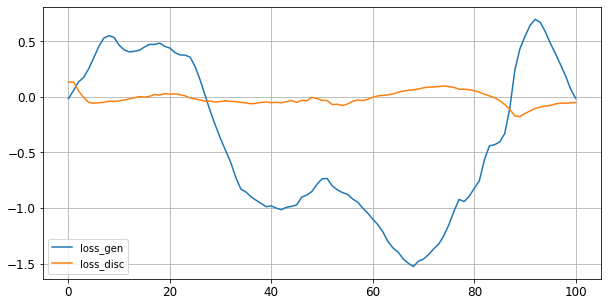

Epoch 102/301
discriminator: -0.034553 - generator: -0.098536 - 1s
Epoch 103/301
discriminator: -0.030478 - generator: -0.166228 - 1s
Epoch 104/301
discriminator: -0.028762 - generator: -0.202430 - 1s
Epoch 105/301
discriminator: -0.021659 - generator: -0.219804 - 1s
Epoch 106/301
discriminator: -0.009567 - generator: -0.289732 - 1s
Epoch 107/301
discriminator: 0.009813 - generator: -0.301296 - 1s
Epoch 108/301
discriminator: 0.017513 - generator: -0.347417 - 1s
Epoch 109/301
discriminator: 0.038899 - generator: -0.395493 - 1s
Epoch 110/301
discriminator: 0.052612 - generator: -0.433387 - 1s
Epoch 111/301
discriminator: 0.068764 - generator: -0.474685 - 1s
Epoch 112/301
discriminator: 0.090365 - generator: -0.528203 - 1s
Epoch 113/301
discriminator: 0.103462 - generator: -0.581794 - 1s
Epoch 114/301
discriminator: 0.120362 - generator: -0.605816 - 1s
Epoch 115/301
discriminator: 0.110886 - generator: -0.596820 - 1s
Epoch 116/301
discriminator: 0.113982 - generator: -0.584548 - 1s
Epoch

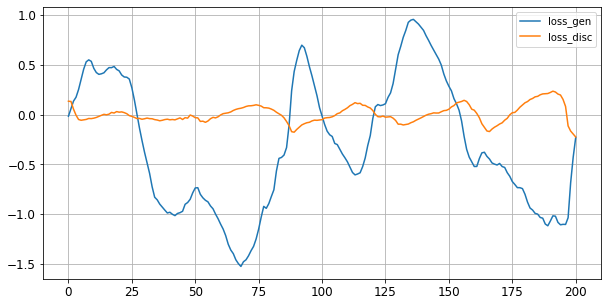

Epoch 202/301
discriminator: -0.240384 - generator: -0.034283 - 1s
Epoch 203/301
discriminator: -0.247690 - generator: 0.171838 - 1s
Epoch 204/301
discriminator: -0.243507 - generator: 0.362409 - 1s
Epoch 205/301
discriminator: -0.247110 - generator: 0.546704 - 1s
Epoch 206/301
discriminator: -0.233698 - generator: 0.695754 - 1s
Epoch 207/301
discriminator: -0.231117 - generator: 0.815205 - 1s
Epoch 208/301
discriminator: -0.206893 - generator: 0.908105 - 1s
Epoch 209/301
discriminator: -0.204532 - generator: 0.944418 - 1s
Epoch 210/301
discriminator: -0.194849 - generator: 1.010192 - 1s
Epoch 211/301
discriminator: -0.182408 - generator: 1.070309 - 1s
Epoch 212/301
discriminator: -0.165293 - generator: 1.135933 - 1s
Epoch 213/301
discriminator: -0.154586 - generator: 1.151538 - 1s
Epoch 214/301
discriminator: -0.149922 - generator: 1.156348 - 1s
Epoch 215/301
discriminator: -0.129489 - generator: 1.159754 - 1s
Epoch 216/301
discriminator: -0.116829 - generator: 1.169996 - 1s
Epoch 217

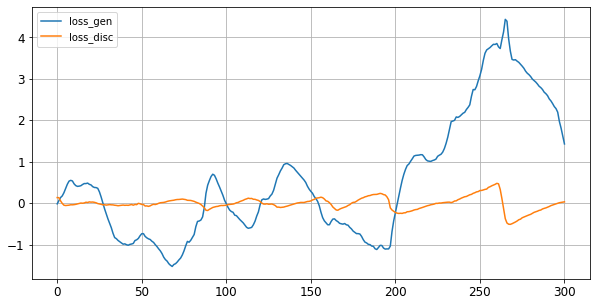

C:\Users\ellye\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
start = time.clock()
hist = train(train_dataset, epochs=301)
elapsed = time.clock() - start

In [26]:
print('Time used:', elapsed)

Time used: 348.05981369299997


_____________

# Data generation

In [27]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, codings_size])
    outp = tf.reshape(outp, [-1, codings_size])
    return mse(inp[:,0], outp[:,0])

In [28]:
def opt_step(latent_values, real_coding):
    '''
    Find the loss between the real_codings and the generated
    values from the latent space
    '''
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output)    

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [29]:
def optimize_coding(real_coding):
    '''
    Use the loss from opt_step to find the optimized 
    latent values
    '''
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.1) 
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(500):
        loss.append(opt_step(latent_values, real_coding).numpy())
                            
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

In [30]:
n = 0
latent_size = 3
codings_size = 2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


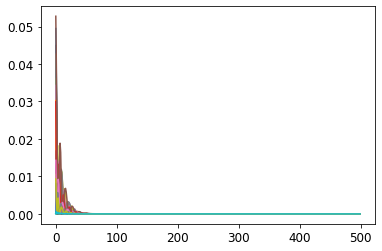

In [31]:
import random
X_generated = np.zeros((1, 2))

predictthis = np.zeros((40, 2))
for n in range(40):
    predictthis[n,1] = random.uniform(-1, 1)
    
    

for n in range(40):
    print(n)
    real_coding = predictthis[n].reshape(1,-1) 
#     real_coding = np.array([0,random.uniform(-1, 1)]).reshape(1,-1)
#     real_coding = X_train_scaled[n].reshape(1,-1)
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)

    latent_values = optimize_coding(real_coding)

    X_generated_1 = scaler.inverse_transform((generator.predict(tf.convert_to_tensor(latent_values)).reshape(1, codings_size)+1)/2)
    X_generated_1 = X_generated_1.reshape(1, 2)
    X_generated = np.concatenate((X_generated, X_generated_1), axis=0)

X_generated = X_generated[1:,:]

In [32]:
print(real_coding)
print(tf.reshape(real_coding, [-1, codings_size]))
print(X_train_scaled[0].reshape(1,-1))
print(np.array([1, 2, 3]))
print(X_generated)

tf.Tensor([[ 0.         -0.18592438]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 0.         -0.18592438]], shape=(1, 2), dtype=float32)
[[0.09115244 0.87237431]]
[1 2 3]
[[0.00158084 0.12349887]
 [0.00158084 0.12153947]
 [0.00158084 0.11157551]
 [0.00158084 0.12557161]
 [0.00158084 0.11564812]
 [0.00158084 0.09631115]
 [0.00158084 0.10505228]
 [0.00158084 0.11825466]
 [0.00158084 0.12514062]
 [0.00158084 0.12441658]
 [0.00158084 0.1057238 ]
 [0.00158084 0.12734173]
 [0.00158084 0.12345392]
 [0.00158084 0.12572873]
 [0.00158084 0.11850192]
 [0.00158084 0.12589684]
 [0.00158084 0.11436792]
 [0.00158084 0.12330177]
 [0.00158084 0.12079981]
 [0.00158084 0.12563396]
 [0.00158084 0.09741366]
 [0.00158084 0.11300987]
 [0.00158084 0.12334768]
 [0.00158084 0.11230002]
 [0.00158084 0.1256019 ]
 [0.00158084 0.11219035]
 [0.00158084 0.11496584]
 [0.00158084 0.12603739]
 [0.00158084 0.11763911]
 [0.00158084 0.1256355 ]
 [0.00158084 0.12569536]
 [0.00158084 0.09838129]
 [0.00158084 0.12538055]
 [0.0

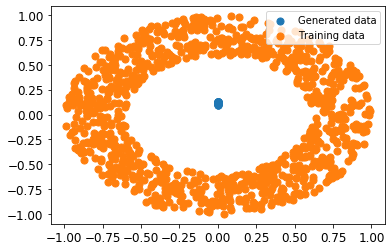

In [33]:
plt.scatter(X_generated[:,0], X_generated[:,1], label="Generated data", s=50)
plt.scatter(X_train[:,0], X_train[:,1], label="Training data", s=50)
#plt.scatter(predictthis[:,0], predictthis[:,1], label="Real data", s=50)
plt.legend(loc='best')
plt.show()